<a href="https://colab.research.google.com/github/joaochenriques/IST---Marine-Currents-and-Tidal-Energy/blob/main/Tidal_Stream/BladeElementMethod/BladeDesign_V10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import subprocess
import pandas as pd
import pathlib
import numpy as np
from scipy.optimize import minimize, root_scalar
from copy import deepcopy

def cmdcall( cmd, verbose = False ):
    output = subprocess.getoutput( cmd )
    if verbose: print(output)

if not pathlib.Path("mpl_utils.py").exists():
  cmdcall( "curl -O https://raw.githubusercontent.com/joaochenriques/ipynb_libs/main/mpl_utils.py" )

import matplotlib.pyplot as mpl
import mpl_utils as mut
mut.config_plots()

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

In [39]:
rad2deg = 180/np.pi
deg2rad = np.pi/180

def SinDist( i: int, n: int, ang0_deg: float = 0 ) -> float:
    if i == n-1: return 1
    if i == 0: return 0
    csi0 = ang0_deg * deg2rad
    dcsi = ( np.pi - 2 * csi0 ) * i / ( n-1 )
    return ( ( np.cos( np.pi - csi0 - dcsi ) + 1.0 ) * 0.5 )

In [245]:
class Data:

    def __init__( self, λ_hub, λ_tip, n, linear=False ):
        self.λ_hub = λ_hub
        self.λ_tip = λ_tip

        if linear:
            self.λ_vec = np.linspace( λ_hub, λ_tip, n )
        else:
            self.λ_vec = np.zeros( n )
            for i in range( n ):
                self.λ_vec[i] = (self.λ_tip - self.λ_hub ) * SinDist( n-1-i, n ) + self.λ_hub

        self.n = n
        self.a_vec  = np.zeros( n )
        self.ap_vec = np.zeros( n )
        self.k_vec  = np.zeros( n )
        self.ϕ0_vec = np.zeros( n )
        self.σ_vec  = np.zeros( n )
        self.CP_vec = np.zeros( n )
        self.CP_tip = 0.0

        self.α_vec  = np.zeros( n )
        self.CL_vec = np.zeros( n )
        self.CD_vec = np.zeros( n )
        self.θ_vec  = np.zeros( n )

In [246]:
_λ_hub = 0.5
_λ_tip = 5.0
_dλ = 0.1

n = int( ( _λ_tip - _λ_hub ) / _dλ + 0.5 ) + 1

dti = Data( _λ_hub, _λ_tip, n ) # data for inviscid flow

print( f'r_hub / R_tip = {_λ_hub/_λ_tip:0.3f}' )
dti.λ_vec

r_hub / R_tip = 0.100


array([5.        , 4.99451911, 4.97810315, 4.9508321 , 4.91283882,
       4.8643084 , 4.80547728, 4.73663208, 4.65810822, 4.57028824,
       4.4736    , 4.36851455, 4.25554386, 4.13523832, 4.00818403,
       3.875     , 3.73633508, 3.59286484, 3.44528824, 3.29432427,
       3.1407084 , 2.98518904, 2.82852387, 2.67147613, 2.51481096,
       2.3592916 , 2.20567573, 2.05471176, 1.90713516, 1.76366492,
       1.625     , 1.49181597, 1.36476168, 1.24445614, 1.13148545,
       1.0264    , 0.92971176, 0.84189178, 0.76336792, 0.69452272,
       0.6356916 , 0.58716118, 0.5491679 , 0.52189685, 0.50548089,
       0.5       ])

In [250]:
class OneAirfoil:

    α_opt = 6.08178 * deg2rad

    @staticmethod
    def data( α, Wm = np.nan ):
        # max( CL/CD ) -> α = 6.08178
        α *= rad2deg
        CL = 0.368 + 0.094 * α
        CD = 3.31333E-3 + (8.63333E-5 + 3.51666E-5 * α) * α
        # CL, CD = 1.5, 0.014
        return CL, CD

MyAirfoil = OneAirfoil()

In [251]:
class AirfoilFromFile:

    def __init__( self, filename ):

        df = df = pd.read_csv( filename, skiprows=[0,1,2,3], usecols=[0,1,3], \
                               names=['alpha', 'CL', 'CD'], sep='\s+' )
        self.alpha = df['alpha'].to_numpy()
        self.CL = df['CL'].to_numpy()
        self.CD = df['CD'].to_numpy()

        CLCD = self.CL / self.CD
        i = np.argmax( CLCD )
        self.α_opt = self.alpha[i] * deg2rad

    def data( self, α, Wm = np.nan ):
        CL = np.interp( α, self.alpha, self.CL )
        CD = np.interp( α, self.alpha, self.CD )
        return CL, CD

MyAirfoil = AirfoilFromFile( 'ClCdDU93-W-210.dat' )

In [252]:
Z = 3
α_des  = MyAirfoil.α_opt
CL_des, CD_des = MyAirfoil.data( α_des )
CL_des, CD_des, α_des*rad2deg

(np.float64(0.5985929188601028),
 np.float64(0.01011679448708775),
 np.float64(8.0))

## Glauert optimal distribution

C_P = -0.5675 -> Glauert


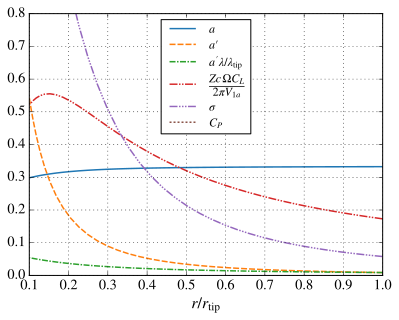

In [253]:
def f(y):
    return -64/5 * y**5 - 72 * y**4 - 124 * y**3 - 38 * y**2 + 63 * y + 12 * np.log(y) + 4 / y

def Integral_f( y2, y1, λ_tip ):
    return 8 / ( 729 * λ_tip**2 ) * ( f(y2) - f(y1) )

CP = 0

for i, λ in enumerate( dti.λ_vec ):

    func = lambda a: 16 * a**3 - 24 * a**2 + 3 * ( 3 - λ**2 ) * a + ( λ**2 - 1 )
    a = root_scalar(func, bracket=[ 1.0/4.0, 1.0/3.0 ], method='brentq' ).root
    ap = ( 1.0 - 3 * a ) / ( 4 * a - 1 )

    ϕ0 = np.arctan( ( 1 - a ) / ( 1 + ap ) / λ )
    σCL  = 4.0 * ap * λ / np.sqrt( ( 1.0 - a )**2 + ( 1.0 + ap )**2 * λ**2 )

    dti.a_vec[i] = a
    dti.ap_vec[i] = ap
    dti.ϕ0_vec[i] = ϕ0
    dti.σ_vec[i] = σCL / CL_des

    if i > 0:
        dti.CP_vec[i] = CP = CP + Integral_f( 1 - 3*dti.a_vec[i], 1 - 3*dti.a_vec[i-1], dti.λ_tip )

x_vec = dti.λ_vec / dti.λ_tip

mpl.plot( x_vec, dti.a_vec,  label = r"$a$" )
mpl.plot( x_vec, dti.ap_vec, label = r"$a\prime$" )
mpl.plot( x_vec, dti.ap_vec*dti.λ_vec/dti.λ_tip, label = r"$a'\lambda/\lambda_\mathrm{tip}$" )
mpl.plot( x_vec, dti.σ_vec* CL_des *dti.λ_vec, label = r"$\dfrac{Zc\,\Omega C_L}{2\pi V_{1a}}$" )
mpl.plot( x_vec, dti.σ_vec, label = r"$\sigma$" )
mpl.plot( x_vec, dti.CP_vec, label = r"$C_P$" )

mpl.xlabel( r"$r/r_\mathrm{tip}$")
mpl.legend( loc="upper center", fontsize=12, handlelength=2.8, \
            labelspacing=0.4 )
mpl.grid()
mpl.ylim( ( 0.0, 0.8 ) )
mpl.savefig( "InductionFactors.pdf" )
print( f"C_P = {dti.CP_vec[-1]:.4f} -> Glauert" )

In [254]:
df = pd.DataFrame( { r"$\lambda$": dti.λ_vec,
                     r"$a$": dti.a_vec,
                     r"$a'$": dti.ap_vec,
                     r"$\phi_0$": dti.ϕ0_vec*rad2deg,
                     r"$C_P$": dti.CP_vec,
                     r"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$": dti.σ_vec*CL_des*dti.λ_vec,
                     r"$\sigma$": dti.σ_vec
                    } )

# print( df.to_latex(index=False,
#        formatters=["{:.2f}".format,"{:.5f}".format,"{:.5f}".format, \
#                    "{:.2f}".format,"{:.3f}".format,"{:.4f}".format]
# ))
df

,$\lambda$,$a$,$a'$,$\phi_0$,$C_P$,"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$",$\sigma$
0,5.000000,0.332367,0.008799,7.539955,0.000000,0.172928,0.057778
1,4.994519,0.332365,0.008818,7.548016,-0.001287,0.173107,0.057902
2,4.978103,0.332359,0.008875,7.572260,-0.005134,0.173647,0.058274
3,4.950832,0.332348,0.008972,7.612878,-0.011495,0.174551,0.058900
4,4.912839,0.332333,0.009110,7.670188,-0.020298,0.175825,0.059788
5,4.864308,0.332314,0.009291,7.744642,-0.031443,0.177479,0.060953
6,4.805477,0.332289,0.009517,7.836833,-0.044802,0.179525,0.062410
7,4.736632,0.332259,0.009793,7.947501,-0.060225,0.181978,0.064183
8,4.658108,0.332224,0.010122,8.077549,-0.077539,0.184856,0.066297
9,4.570288,0.332182,0.010510,8.228048,-0.096553,0.188181,0.068786


## Computing the turbine blade (Glauert's solution)

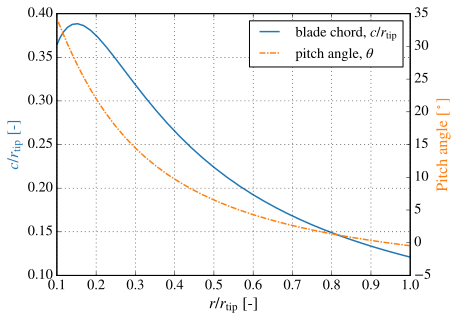

In [255]:
σ_factor = 2.0 * np.pi / Z

θ_vec = dti.ϕ0_vec - α_des
cR_vec = dti.σ_vec * σ_factor *  dti.λ_vec / dti.λ_tip
rR_vec = dti.λ_vec / dti.λ_tip

ax1 = mpl.gca()
ax1.plot( rR_vec, cR_vec, mut.linecolors[0], label=r"blade chord, $c/r_\mathrm{tip}$" )
ax1.set_ylabel( r"$c/r_\mathrm{tip}$ [-]", color=mut.linecolors[0] )
ax1.set_xlabel( r"$r/r_\mathrm{tip}$ [-]")
ax1.grid()
# ax1.set_ylim( 0, 0.25 )

ax2 = mpl.gca().twinx()
ax2.plot( rR_vec, θ_vec * rad2deg, mut.linecolors[1], \
          dashes=mut.linestyles[2], label=r'pitch angle, $\theta$' )
ax2.tick_params(axis='y' )
ax2.set_ylabel( r"Pitch angle [$^\circ$]", color=mut.linecolors[1] )
# ax2.set_ylim( 0, 50 )
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right' )

mpl.savefig( "TurbineBlade.pdf" )

In [265]:
def tip_loss( a, ap, ϕ, ϕ0, λ, λtip ):
    # a = min( (a, 1-1E-14) )
    ff = 0.5 * Z * ( λtip / λ - 1 ) * np.sqrt( 1 + ( λ / ( 1 - a ) )**2 )
    rr =  np.max( ( 2.0 / np.pi * np.arccos( np.exp( -ff ) ), 1E-3 ) )

    # ff = 0.5 * Z * λtip / λ / np.tan( ϕ ) - 0.5
    # rr =  2.0 / np.pi * np.arccos( np.cosh( λtip / λ* ff ) / np.cosh( ff ) )
    # print( ff, np.cosh( λtip / λ* ff ), np.cosh( ff ), rr )
    return rr

In [266]:
# The initial viscous solution is the invisc flow results
dtv = deepcopy( dti ) # deepcopy avoids references

for i, λ in enumerate( dti.λ_vec ):

    ϕ = np.atan( 1 / λ )
    a = dti.a_vec[i]
    ap = dti.ap_vec[i]
    σ = dti.σ_vec[i]

    for j in range( 400 ):

        a_mo = a
        ap_mo = ap

        ϕ0 = np.atan2( ( 1 - a ), ( 1 + ap ) * λ )
        cosϕ0 = np.cos( ϕ0 )
        sinϕ0 = np.sin( ϕ0 )

        Ca = CL_des * cosϕ0 + CD_des * sinϕ0
        Ct = CL_des * sinϕ0 - CD_des * cosϕ0

        a  = σ * Ca / ( 4 * sinϕ0**2 + σ * Ca )
        ap = σ * Ct / ( 4 * sinϕ0*cosϕ0 - σ * Ct )

        if np.abs( a - a_mo ) < 1E-6 and np.abs( ap - ap_mo ) < 1E-6:
            break

    k = tip_loss( a, ap, ϕ, ϕ0, λ, dtv.λ_tip )

    dtv.ϕ0_vec[i] = ϕ0
    dtv.a_vec[i] = a
    dtv.ap_vec[i] = ap
    dtv.k_vec[i] = k
    dtv.σ_vec[i] = dti.σ_vec[i]
    dtv.θ_vec[i] = ϕ0 - α_des

# integrate CP using trapezoidal rule
CP = 0
fct = 8 / dtv.λ_tip**2
for i in range( 1, len( dti.λ_vec ) ):
    k = i - 1
    d_λ = ( dtv.λ_vec[i] - dtv.λ_vec[k] )
    f_k = dtv.k_vec[k] * dtv.ap_vec[k] * ( 1 - dtv.a_vec[k] ) * dtv.λ_vec[k]**3
    f_i = dtv.k_vec[i] * dtv.ap_vec[i] * ( 1 - dtv.a_vec[i] ) * dtv.λ_vec[i]**3
    dtv.CP_vec[i] = CP = CP + fct * 0.5 * ( f_i + f_k ) * d_λ

print( f"C_P = {CP:.4f} -> Viscous flow" )

C_P = -0.4587 -> Viscous flow


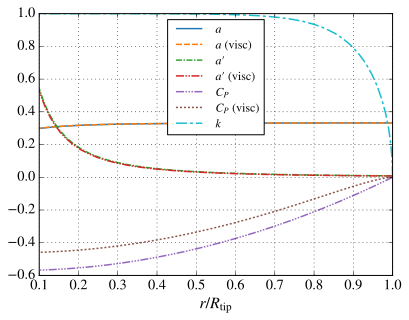

In [267]:
rR_vec = dtv.λ_vec / dtv.λ_tip

mpl.plot( rR_vec, dti.a_vec,  label = r"$a$" )
mpl.plot( rR_vec, dtv.a_vec,  label = r"$a$ (visc)" )
mpl.plot( rR_vec, dti.ap_vec, label = r"$a\prime$" )
mpl.plot( rR_vec, dtv.ap_vec, label = r"$a\prime$ (visc)" )
mpl.plot( rR_vec, dti.CP_vec, label = r"$C_P$" )
mpl.plot( rR_vec, dtv.CP_vec, label = r"$C_P$ (visc)" )
mpl.plot( rR_vec, dtv.k_vec,  label = r"$k$" )

mpl.xlabel( r"$r/R_\mathrm{tip}$")
mpl.legend( loc="upper center", fontsize=12, handlelength=2.8, \
            labelspacing=0.4 )
mpl.grid()
# mpl.ylim( ( 0.0, 1.05 ) )
mpl.savefig( "InductionFactors.pdf" )

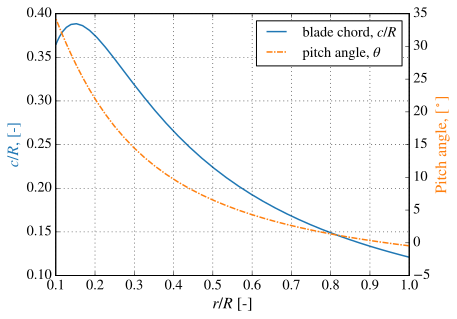

In [268]:
cR_vec = dtv.σ_vec * σ_factor *  dtv.λ_vec / dtv.λ_tip
rR_vec = dtv.λ_vec / dtv.λ_tip

mpl.figure(4)
ax1 = mpl.gca()
ax1.plot( rR_vec, cR_vec, mut.linecolors[0], label=r"blade chord, $c/R$" )
ax1.set_ylabel( r"$c/R$, [-]", color=mut.linecolors[0] )
ax1.set_xlabel( r"$r/R$ [-]")
ax1.grid()
# ax1.set_ylim( 0, 0.25 )

ax2 = mpl.gca().twinx()
ax2.plot( rR_vec, θ_vec * rad2deg, mut.linecolors[1], \
          dashes=mut.linestyles[2], label=r'pitch angle, $\theta$' )
ax2.tick_params(axis='y' )
ax2.set_ylabel( r"Pitch angle, [$^\circ$]", color=mut.linecolors[1] )
# ax2.set_ylim( 0, 50 )
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper right' )

mpl.savefig( "TurbineBlade_visc.pdf" )

In [269]:
df = pd.DataFrame( { r"$\lambda$": dtv.λ_vec,
                     r"$a$": dtv.a_vec,
                     r"$a'$": dtv.ap_vec,
                     r"$\phi_0$": dtv.ϕ0_vec*rad2deg,
                     r"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$": dtv.σ_vec*CL_des*dtv.λ_vec,
                     r"$\sigma$": dtv.σ_vec
                    } )

# print( df.to_latex(index=False,
#        formatters=["{:.2f}".format,"{:.5f}".format,"{:.5f}".format, \
#                    "{:.2f}".format,"{:.3f}".format,"{:.4f}".format]
# ))
df

,$\lambda$,$a$,$a'$,$\phi_0$,"$\frac{Zc\,\Omega C_L}{2\pi V_{1a}}$",$\sigma$
0,5.000000,0.332377,0.007668,7.548197,0.172928,0.057778
1,4.994519,0.332375,0.007686,7.556275,0.173107,0.057902
2,4.978103,0.332369,0.007740,7.580572,0.173647,0.058274
3,4.950832,0.332359,0.007830,7.621278,0.174551,0.058900
4,4.912839,0.332344,0.007959,7.678713,0.175825,0.059788
5,4.864308,0.332324,0.008128,7.753332,0.177479,0.060953
6,4.805477,0.332300,0.008341,7.845728,0.179525,0.062410
7,4.736632,0.332271,0.008599,7.956646,0.181978,0.064183
8,4.658108,0.332236,0.008908,8.086992,0.184856,0.066297
9,4.570288,0.332194,0.009272,8.237841,0.188181,0.068786


In [275]:
λ_off = 4
rat = λ_off / _λ_tip
dta = Data( _λ_hub * rat, _λ_tip * rat, dtv.n )
# dta = deepcopy( dtv )

fr = 0.25
omfr = 1 - fr
Found = False

for i, λ in enumerate( dta.λ_vec ):

    if i == 0:
        a  = dtv.a_vec[i]
        ap = dtv.ap_vec[i]

    σ = dti.σ_vec[i]
    θ = dtv.θ_vec[i]

    for j in range( 400 ):

        a_mo = a
        ap_mo = ap

        ϕ0 = np.atan2( ( 1 - a ), ( 1 + ap ) * λ )
        cosϕ0 = np.cos( ϕ0 )
        sinϕ0 = np.sin( ϕ0 )

        α = ϕ0 - θ
        CL, CD = MyAirfoil.data( α )

        Ca = CL * cosϕ0 + CD * sinϕ0
        Ct = CL * sinϕ0 - CD * cosϕ0

        a  = σ * Ca / ( 4 * sinϕ0**2 + σ * Ca )
        ap = σ * Ct / ( 4 * sinϕ0*cosϕ0 - σ * Ct )

        a = fr * a + a_mo * omfr
        ap = fr * ap + ap_mo * omfr

        error = np.max( (np.abs( a - a_mo ), np.abs( ap - ap_mo ) ) )

        if error < 1E-6:
            Found = True
            break

    if not Found:
        print( f'ERROR max = {error:.4E}' )

    rR = λ / dta.λ_tip
    print( f'\ti = {i}, ϕ0 = {ϕ0*rad2deg:.4f}, α = {α*rad2deg:.4f} a = {a:.6f}, ap = {ap:.6f}, r/R = {rR:.6f}' )

    k = tip_loss( a, ap, ϕ, ϕ0, λ, dta.λ_tip )

    dta.a_vec[i] = a
    dta.ap_vec[i] = ap
    dta.k_vec[i] = k
    dta.σ_vec[i] = σ

    dta.α_vec[i] = α
    dta.CL_vec[i] = CL
    dta.CD_vec[i] = CD

# integrate CP using trapezoidal rule
CP = 0
fct = 8 / dta.λ_tip**2
for i in range( 1, len( dta.λ_vec ) ):
    k = i - 1
    d_λ = ( dta.λ_vec[i] - dta.λ_vec[k] )
    f_k = dta.k_vec[k] * dta.ap_vec[k] * ( 1 - dta.a_vec[k] ) * dta.λ_vec[k]**3
    f_i = dta.k_vec[i] * dta.ap_vec[i] * ( 1 - dta.a_vec[i] ) * dta.λ_vec[i]**3
    dta.CP_vec[i] = CP = CP + fct * 0.5 * ( f_i + f_k ) * d_λ

print( f"C_P = {CP:.4f} -> Viscous flow" )

	i = 0, ϕ0 = 11.5236, α = 11.9754 a = 0.177717, ap = 0.008287, r/R = 1.000000
	i = 1, ϕ0 = 11.5357, α = 11.9794 a = 0.177718, ap = 0.008304, r/R = 0.998904
	i = 2, ϕ0 = 11.5717, α = 11.9912 a = 0.177743, ap = 0.008363, r/R = 0.995621
	i = 3, ϕ0 = 11.6320, α = 12.0108 a = 0.177787, ap = 0.008460, r/R = 0.990166
	i = 4, ϕ0 = 11.7171, α = 12.0384 a = 0.177850, ap = 0.008599, r/R = 0.982568
	i = 5, ϕ0 = 11.8275, α = 12.0742 a = 0.177932, ap = 0.008780, r/R = 0.972862
	i = 6, ϕ0 = 11.9641, α = 12.1184 a = 0.178033, ap = 0.009007, r/R = 0.961095
	i = 7, ϕ0 = 12.1279, α = 12.1712 a = 0.178157, ap = 0.009284, r/R = 0.947326
	i = 8, ϕ0 = 12.3201, α = 12.2331 a = 0.178302, ap = 0.009615, r/R = 0.931622
	i = 9, ϕ0 = 12.5422, α = 12.3043 a = 0.178472, ap = 0.010007, r/R = 0.914058
	i = 10, ϕ0 = 12.7958, α = 12.3854 a = 0.178668, ap = 0.010465, r/R = 0.894720
	i = 11, ϕ0 = 13.0830, α = 12.4767 a = 0.178894, ap = 0.010998, r/R = 0.873703
	i = 12, ϕ0 = 13.4059, α = 12.5788 a = 0.179152, ap = 0.011618

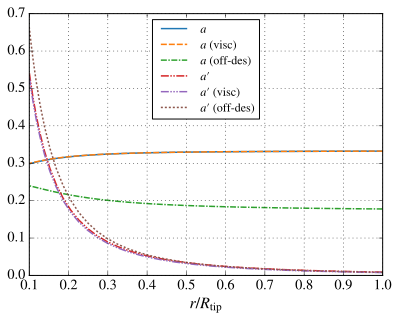

In [276]:
rR_vec = dta.λ_vec / dta.λ_tip

mpl.plot( rR_vec, dti.a_vec,  label = r"$a$" )
mpl.plot( rR_vec, dtv.a_vec,  label = r"$a$ (visc)" )
mpl.plot( rR_vec, dta.a_vec,  label = r"$a$ (off-des)" )
mpl.plot( rR_vec, dti.ap_vec, label = r"$a\prime$" )
mpl.plot( rR_vec, dtv.ap_vec, label = r"$a\prime$ (visc)" )
mpl.plot( rR_vec, dta.ap_vec, label = r"$a\prime$ (off-des)" )
# mpl.plot( rR_vec, dti.CP_vec, label = r"$C_P$" )
# mpl.plot( rR_vec, dtv.CP_vec, label = r"$C_P$ (visc)" )
# mpl.plot( rR_vec, dtv.k_vec, label = r"$k$" )

mpl.xlabel( r"$r/R_\mathrm{tip}$")
mpl.legend( loc="upper center", fontsize=12, handlelength=2.8, \
            labelspacing=0.4 )
mpl.grid()
# mpl.ylim( ( 0.0, 1.05 ) )

In [237]:
df = pd.DataFrame( { r"$\lambda$": dta.λ_vec,
                     r"$a$": dta.a_vec,
                     r"$a'$": dta.ap_vec,
                     r"$\phi_0$": dta.ϕ0_vec*rad2deg,
                     r"$\kappa$": dta.k_vec,
                     r"$\sigma$": dta.σ_vec,
                     r"$\alpha$": dta.α_vec*rad2deg,
                     r"$C_L$": dta.CL_vec,
                     r"$C_D$": dta.CD_vec,
                    } )

# print( df.to_latex(index=False,
#        formatters=["{:.2f}".format,"{:.5f}".format,"{:.5f}".format, \
#                    "{:.2f}".format,"{:.3f}".format,"{:.4f}".format]
# ))
df

,$\lambda$,$a$,$a'$,$\phi_0$,$\kappa$,$\sigma$,$\alpha$,$C_L$,$C_D$
0,0.500000,0.299329,0.529996,0.0,1.000000,1.739085,8.000012,0.598593,0.010117
1,0.505481,0.299639,0.521688,0.0,1.000000,1.725992,7.999978,0.598593,0.010117
2,0.521897,0.300542,0.497958,0.0,1.000000,1.687368,7.999962,0.598593,0.010117
3,0.549168,0.301979,0.461983,0.0,1.000000,1.625153,7.999955,0.598593,0.010117
4,0.587161,0.303856,0.418023,0.0,1.000000,1.542450,7.999935,0.598593,0.010117
5,0.635692,0.306059,0.370393,0.0,0.999999,1.443320,7.999933,0.598593,0.010117
6,0.694523,0.308463,0.322716,0.0,0.999999,1.332472,7.999910,0.598593,0.010117
7,0.763368,0.310948,0.277590,0.0,0.999997,1.214874,7.999888,0.598593,0.010117
8,0.841892,0.313408,0.236581,0.0,0.999995,1.095324,7.999894,0.598593,0.010117
9,0.929712,0.315758,0.200408,0.0,0.999990,0.978057,7.999879,0.598593,0.010117


In [238]:
i = 9
a  = dta.a_vec[i]
ap = dta.ap_vec[i]
λ = dta.λ_vec[i]
ϕ0 = dta.ϕ0_vec[i]

ff = 0.5 * Z * ( dta.λ_tip / λ - 1 ) * np.sqrt( 1 + ( λ / ( 1 - a ) )**2 )
rr =  np.max( ( 2.0 / np.pi * np.arccos( np.exp( -ff ) ), 1E-3 ) )

ff, rr, a, (1-a)

(np.float64(11.078998180477212),
 np.float64(0.9999901750047703),
 np.float64(0.3157584591737108),
 np.float64(0.6842415408262892))